# Natural Language Classification with Project Gutenberg

We have taken a corpus of cleaned public domain books from Project Gutenberg. The corpus has been preprocessed in a separate notebook in order to avoid using unnecessary computational power each time this notebook is opened.

## Abstract

**Goal:** Our goal is to classify texts from Project Gutenberg by author. 

**Hypothesis:** Our hypothesis is that each author uses a certain set of words, and we can train the machine to learn this "signature" and classify texts by author.

We have created a TF-IDF model of each document. This means the value associated with each word in each document is equal to the **term frequency**, i.e. the number of times the word appears in the document divided by the length, times the **inverse document frequency**, i.e. the total number of documents in the corpus divided by the number of documents containing the word.

The text processing and machine learning functions we are using for this project are from [scikit-learn](http://scikit-learn.org/stable/index.html), and we will be using [amueller's wordcloud library.](https://github.com/amueller/word_cloud)

We will start by exploring the data with some word clouds. Then we will use a Naive Bayes algorithm to classify the unigram model of the corpus by author. We will then train the same classifier on a bigram model with an increase in accuracy to 92.14%.

In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [2]:
author_title_df = pd.read_csv('author_title.csv', index_col=0)
X = joblib.load('features.pkl')
X = X.toarray()
vocabulary = joblib.load('feature_names.pkl')

Y = author_title_df.Author

Word clouds are a relatively easy to understand way to visualize text data while still being somewhat information dense, so it will help to show word clouds for a few selected authors.

(-0.5, 799.5, 649.5, -0.5)

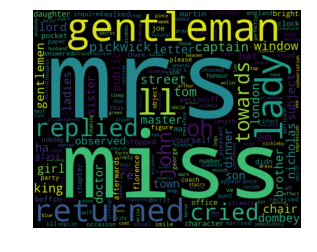

In [7]:
%matplotlib inline

dickens_docs = author_title_df.loc[Y == 'Charles Dickens', 'Name']
vectorizer = CountVectorizer(input='filename',
                             min_df=3, max_df=.85,
                             encoding='iso-8859-1')
vectorizer.fit(('txt/' + fname for fname in author_title_df.Name))
dickens_counts = vectorizer.transform(('txt/' + fname for fname in dickens_docs)).sum(axis=0)
dickens_wordfreq = {w:dickens_counts.item(i) for w,i in vectorizer.vocabulary_.items()}

wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(dickens_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 799.5, 649.5, -0.5)

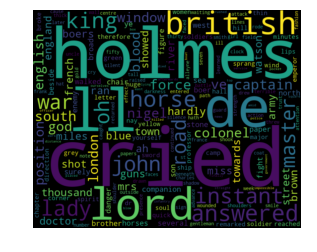

In [8]:
doyle_docs = author_title_df.loc[Y == 'Sir Arthur Conan Doyle', 'Name']
doyle_counts = vectorizer.transform(('txt/' + fname for fname in doyle_docs)).sum(axis=0)
doyle_wordfreq = {w:doyle_counts.item(i) for w,i in vectorizer.vocabulary_.items()}
wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(doyle_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 799.5, 649.5, -0.5)

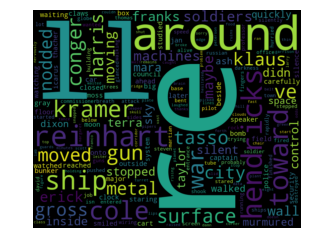

In [9]:
pkd_docs = author_title_df.loc[Y == 'Philip Kindred Dick', 'Name']
pkd_counts = vectorizer.transform(('txt/' + fname for fname in pkd_docs)).sum(axis=0)
pkd_wordfreq = {w:pkd_counts.item(i) for w,i in vectorizer.vocabulary_.items()}
wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(pkd_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

It's worth noting that aside from just showing that different words are used, the word clouds show different themes, some of which are somewhat surprising. Dick uses more contractions than Doyle or Dickens, which makes sense as he is the only 20th century writer out of the three. many of Doyle's books are from the same series, so the word Holmes appears more than any names in the other two books.

Note also that the character 'â' appears in multiple places in the last word cloud. We have assumed that every document was encoded with ISO-8859-1, and I believe some of them are, but then again this character probably does not appear much in the original texts. If these words appears here as an encoding error, there is not much to do for now.

Now on to the classification. We will first split the data into train and test sets. Here we are using 30% of the data as the test set.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.3,
                                                    random_state = 4)

Naive Bayes only has one main parameter, which is the regularization parameter alpha. We will tune this using scikit-learn's grid search cross-validation.

In [7]:
clf = MultinomialNB()
params = {'alpha':np.logspace(-7,1,9)}
gridcv = GridSearchCV(clf, param_grid = params)
gridcv.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-07,   1.00000e-06,   1.00000e-05,   1.00000e-04,
         1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
gridcv.best_estimator_

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

In [9]:
%%time
clf = MultinomialNB(alpha = .0001)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))

0.905952380952
CPU times: user 11.2 s, sys: 1.48 s, total: 12.7 s
Wall time: 8.2 s


We have been using a Bag of Words unigram model, where it simply looks at the (idf adjusted) frequency of each word in the document. Sometimes, however, it is helpful to look at the interactions between words.

Our next step will look at a bigram model, where each feature represents two adjacent words. It performs slower but we will expect here to see some improvement in accuracy.

In [7]:
%%time
vectorizer = TfidfVectorizer(input='filename', min_df=3, max_df=.95, ngram_range=(2,2), encoding='iso-8859-1')
X_bigram = vectorizer.fit_transform(['txt/'+fname for fname in author_title_df.Name])

X_train, X_test, Y_train, Y_test = train_test_split(X_bigram, Y,
                                                              test_size = 0.3,
                                                              random_state = 4
                                                             )

CPU times: user 14min 22s, sys: 1min 10s, total: 15min 33s
Wall time: 17min 37s


In [18]:
X_train.shape

(1958, 3613484)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

clfs = [MultinomialNB(alpha=.0001),
        KNeighborsClassifier(20),
        RandomForestClassifier(200, max_features=0.25, n_jobs=-1),
        GradientBoostingClassifier(n_estimators=200,max_features=0.5)]
le = LabelEncoder()
le.fit(Y)

for clf in clfs:
    try:
        X_stacked_train
    except:
        X_stacked_train= sparse.hstack((X_train,
                                        le.transform(cross_val_predict(clf, X_train, Y_train, cv=4)).reshape(1958,1)))
    else:
        X_stacked_train= sparse.hstack((X_stacked_train, 
                                        le.transform(cross_val_predict(clf, X_train, Y_train, cv=4)).reshape(1958,1)))

In [ ]:
%%time
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
params = {'C':[0.01,0.1,1,10]}
gridcv = GridSearchCV(lr, param_grid = params, cv=4)
gridcv.fit(X[:20,:], Y[:20])
print(gridcv.best_estimator_)
print(gridcv.best_score_)

In [11]:
%%time
clf = MultinomialNB(alpha = .0001)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))

0.921428571429
CPU times: user 1min, sys: 38.5 s, total: 1min 39s
Wall time: 2min 14s


## In Action

In order to demonstrate the power of our bigram classifier we have added an extra text file outside the corpus. It is Abraham Lincoln's reply to Douglass in one their famous debates. One of the documents in the corpus is a collection of Lincoln speeches which includes this debate, though possibly not transcribed identically. Because we are using a TF-IDF vectorizer, the matrix for our test document will be close slightly different to the document which contains this as a subset. We expect that it will correctly predict the author to be 'Abraham Lincoln.'

In [12]:
lincoln_test = vectorizer.transform(['txt/Lincoln_Test.txt'])
print(clf.predict(lincoln_test))

['Abraham Lincoln']


# Conclusion:

Our initial classifier on a unigram model had fairly high accuracy, at **90.6%**. The bigram model showed an improvement in accuracy at **92.1%**, a fairly large increase considering that we had already beaten the 90% threshold. However, this increase in accuracy comes at an increased computational cost. The classifier was noticeably slower, with the unigram classifier taking less than **13 seconds** and the bigram classifier taking **99 seconds**. The main source of the decreased performance, however, was in the tokenization step. We will rebuild the unigram model below to show that it takes **4 minutes and 15 seconds** to build, while the bigram model took **15 minutes and 31 seconds** to build.

We could try a trigram model as well, and the accuracy might again increase but at a very great computational cost due to the number and length of the documents.

In [13]:
%%time
vectorizer = TfidfVectorizer(input='filename', min_df=3, max_df=.95, encoding='iso-8859-1')
tokens = vectorizer.fit_transform(['txt/'+fname for fname in author_title_df.Name])

CPU times: user 3min 54s, sys: 20.7 s, total: 4min 15s
Wall time: 4min 25s


### Future Considerations

We saw earlier that the word clouds tended to have patterns for different authors. These themes might be interesting to explore with unsupervised learning methods such as clustering. Also, we could use more variations on Bag of Words such as skip-grams, where we look not only at adjacent words but also words within an allowable space to try to improve our classifier even further. Models based on word embedding such as word2vec may also be useful here, though there would be a performance cost.